In [4]:
import os
import re
import sqlite3

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset

# ПОТОМ АВТОМАТИЗИРОВАТЬ СОЗДАНИЕ ЭТИХ МАППИНГОВ
type_mapping = {
    "electricity": 1,
    "cold_water": 2,
    "hot_water": 3,
    "heat": 4,
}

weather_type_mapping = {
    "малооблачно без осадков": 1,
    "малооблачно гроза": 2,
    "малооблачно осадки": 3,
    "малооблачно сильный снег": 4,
    "малооблачно сильный туман": 5,
    "малооблачно слабый дождь": 6,
    "малооблачно слабый снег": 7,
    "малооблачно слабый туман": 8,
    "малооблачно снег": 9,
    "малооблачно туман": 10,
    "облачно без осадков": 11,
    "облачно гроза": 12,
    "облачно дождь": 13,
    "облачно сильный дождь": 14,
    "облачно сильный туман": 15,
    "облачно слабые осадки": 16,
    "облачно слабый дождь": 17,
    "облачно слабый снег": 18,
    "облачно слабый туман": 19,
    "облачно снег": 20,
    "пасмурно без осадков": 21,
    "пасмурно гроза": 22,
    "пасмурно дождь": 23,
    "пасмурно сильный дождь": 24,
    "пасмурно сильный снег": 25,
    "пасмурно сильный туман": 26,
    "пасмурно слабые осадки": 27,
    "пасмурно слабый дождь": 28,
    "пасмурно слабый снег": 29,
    "пасмурно слабый туман": 30,
    "пасмурно снег": 31,
    "ясно без осадков": 32
}

city_mapping = {
    "Владивосток": 1,
    "Артем": 2,
}

russian_alphabet = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
letter_mapping = {letter: i + 1 for i, letter in enumerate(russian_alphabet)}


In [5]:
pd.set_option('future.no_silent_downcasting', True)

def load_data_from_db(
    db_path="d:/code/ps_farpost_2025/databases/dataset.db",
    weather_db_path="d:/code/ps_farpost_2025/databases/weather.db",
):
    """Загрузка данных об отключениях и погоде из баз данных SQLite"""

    print(f"Подключение к базе данных: {db_path}")
    conn = sqlite3.connect(db_path)

    # --- Создание маппингов ---
    print("Создание маппингов...")

    # street
    street_df = pd.read_sql_query("SELECT DISTINCT name FROM streets WHERE name IS NOT NULL", conn)
    street_mapping = {name: i for i, name in enumerate(street_df['name'], 1)}
    joblib.dump(street_mapping, 'street_mapping.joblib')

    # district (unified)
    district_query = """
    SELECT name FROM folk_districts WHERE name IS NOT NULL
    UNION
    SELECT name FROM big_folk_districts WHERE name IS NOT NULL
    UNION
    SELECT name FROM districts WHERE name IS NOT NULL
    """
    district_df = pd.read_sql_query(district_query, conn)
    district_mapping = {name: i for i, name in enumerate(district_df['name'], 1)}
    joblib.dump(district_mapping, 'district_mapping.joblib')
    
    print("Маппинги созданы и сохранены.")

    query = """
    SELECT
        b.start_date,
        b.end_date,
        b.description,
        b.type,
        c.name as city,
        s.name as street,
        bu.number as house_number,
        COALESCE(fd.name, bfd.name, d.name, -1) as district
    FROM blackouts b
    JOIN blackouts_buildings bb ON b.id = bb.blackout_id
    JOIN buildings bu ON bb.building_id = bu.id
    JOIN streets s ON bu.street_id = s.id
    JOIN cities c ON bu.city_id = c.id
    LEFT JOIN folk_districts fd ON bu.folk_district_id = fd.id
    LEFT JOIN big_folk_districts bfd ON bu.big_folk_district_id = bfd.id
    LEFT JOIN districts d ON bu.district_id = d.id
    """

    print("Выполнение SQL-запроса для извлечения данных...")
    df = pd.read_sql_query(query, conn)
    conn.close()

    print(f"Загружено {len(df)} записей из базы данных.")

    # --- Фильтрация плановых отключений ---
    # initial_count = len(df)
    # df = df[~df['description'].str.contains("планов", case=False, na=False)]
    # excluded_count = initial_count - len(df)
    # print(f"Исключено {excluded_count} записей, содержащих 'планов' в описании.")

    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])

    # --- Feature Engineering ---
    df['start_month'] = df['start_date'].dt.month
    df['start_dayofweek'] = df['start_date'].dt.dayofweek
    df['start_hour'] = df['start_date'].dt.hour
    
    # --- Улучшенная векторизация текста (Word2Vec) ---
    print("Векторизация описаний с помощью Word2Vec...")
    # Простая токенизация
    tokenized_descriptions = [re.findall(r'\b\w+\b', desc.lower()) for desc in df['description']]
    
    # Обучение модели Word2Vec
    w2v_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)
    w2v_model.save("word2vec.model")
    print("Модель Word2Vec обучена и сохранена в 'word2vec.model'")
    
    # Функция для получения вектора для описания
    def description_to_vector(description_tokens, model):
        vectors = [model.wv[word] for word in description_tokens if word in model.wv]
        if not vectors:
            return np.zeros(model.vector_size)
        return np.mean(vectors, axis=0)

    # Применение векторизации
    description_vectors = np.array([description_to_vector(tokens, w2v_model) for tokens in tokenized_descriptions])
    description_vectors_df = pd.DataFrame(
        description_vectors,
        columns=[f"desc_vec_{i}" for i in range(w2v_model.vector_size)],
    )
    df = pd.concat([df.reset_index(drop=True), description_vectors_df], axis=1)
    df = df.drop(columns=["description"])
    print("Описания векторизованы с помощью Word2Vec.")


    # Обработка номера дома
    df["house_number_letter"] = (
        df["house_number"].str.extract(r"(\D+)", expand=False).str.lower().fillna("")
    )
    df["house_number_letter"] = df["house_number_letter"].apply(
        lambda x: letter_mapping.get(x, -1)
    )
    df["house_number"] = df["house_number"].str.extract(r"(\d+)").astype(float)

    # Загрузка данных о погоде
    print(f"Подключение к базе данных погоды: {weather_db_path}")
    weather_conn = sqlite3.connect(weather_db_path)
    weather_query = "SELECT date, temp_max, temp_min, weather_type FROM weather"
    print("Выполнение SQL-запроса для извлечения данных о погоде...")
    weather_df = pd.read_sql_query(weather_query, weather_conn)
    weather_conn.close()
    print(f"Загружено {len(weather_df)} записей о погоде.")

    weather_df["date"] = pd.to_datetime(weather_df["date"])
    weather_df["temp_min"] = pd.to_numeric(weather_df["temp_min"], errors="coerce")
    weather_df["temp_max"] = pd.to_numeric(weather_df["temp_max"], errors="coerce")
    weather_df = weather_df.rename(columns={"weather_type": "weather_description"})

    # Объединение данных
    df["merge_date"] = df["start_date"].dt.date
    weather_df["merge_date"] = weather_df["date"].dt.date
    df = pd.merge(df, weather_df, on="merge_date", how="left")
    df = df.drop(columns=["merge_date", "date"])

    # Применение маппингов
    print("Применение маппингов...")
    df["type"] = df["type"].map(type_mapping)
    df["weather_description"] = df["weather_description"].map(weather_type_mapping)
    df["city"] = df["city"].map(city_mapping)
    df["street"] = df["street"].map(street_mapping)
    df["district"] = df["district"].map(district_mapping)
    print("Маппинги применены.")

    return df


def display_data():
    """Загружает и выводит первые 5 строк объединенных данных."""
    print("Загрузка данных...")
    data = load_data_from_db()
    pd.set_option("display.max_columns", None)
    print("Объединенные данные (первые 5 строк):")
    print(data.head())


display_data()


Загрузка данных...
Подключение к базе данных: d:/code/ps_farpost_2025/databases/dataset.db
Создание маппингов...
Маппинги созданы и сохранены.
Выполнение SQL-запроса для извлечения данных...
Загружено 175590 записей из базы данных.
Векторизация описаний с помощью Word2Vec...
Загружено 175590 записей из базы данных.
Векторизация описаний с помощью Word2Vec...
Модель Word2Vec обучена и сохранена в 'word2vec.model'
Модель Word2Vec обучена и сохранена в 'word2vec.model'
Описания векторизованы с помощью Word2Vec.
Описания векторизованы с помощью Word2Vec.
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 730 записей о погоде.
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 730 записей о погоде.
Применение маппингов...
Маппинги применены.
Объединенные данные (первые 5 строк):
           start_date    

In [6]:
# Загрузка и предварительная обработка данных
df = load_data_from_db()

# Удаление строк с отсутствующими значениями в start_date или end_date
df.dropna(subset=['start_date', 'end_date'], inplace=True)

# Вычисление целевой переменной - длительности отключения в часах
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 3600

# Удаление аномалий (например, отрицательная или очень большая длительность)
df = df[(df['duration'] >= 0) & (df['duration'] < 1000)]

# --- НОВЫЙ ШАГ: Удаление всех строк с любыми пропущенными значениями в duration ---
df.dropna(subset=['duration'], inplace=True)

# Вывод информации о данных
print("Данные после вычисления длительности и очистки:")
print(df.head())
print(df.info())

Подключение к базе данных: d:/code/ps_farpost_2025/databases/dataset.db
Создание маппингов...
Маппинги созданы и сохранены.
Выполнение SQL-запроса для извлечения данных...
Загружено 175590 записей из базы данных.
Векторизация описаний с помощью Word2Vec...
Загружено 175590 записей из базы данных.
Векторизация описаний с помощью Word2Vec...
Модель Word2Vec обучена и сохранена в 'word2vec.model'
Модель Word2Vec обучена и сохранена в 'word2vec.model'
Описания векторизованы с помощью Word2Vec.
Описания векторизованы с помощью Word2Vec.
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 730 записей о погоде.
Применение маппингов...
Подключение к базе данных погоды: d:/code/ps_farpost_2025/databases/weather.db
Выполнение SQL-запроса для извлечения данных о погоде...
Загружено 730 записей о погоде.
Применение маппингов...
Маппинги применены.
Данные после вычисления длительности и очистки:
          

In [7]:
# --- Конфигурация типов отключений и подготовка наборов данных ---


TYPE_CONFIGS = {
    "electricity": {
        "type_id": type_mapping["electricity"],
        "duration_limit": 24,
        "model_path": "improved_duration_predictor_electricity.pth",
        "scaler_path": "duration_scaler_electricity.joblib",
    },
    "cold_water": {
        "type_id": type_mapping["cold_water"],
        "duration_limit": 80,
        "model_path": "improved_duration_predictor_cold_water.pth",
        "scaler_path": "duration_scaler_cold_water.joblib",
    },
    # "hot_water": {
    #     "type_id": type_mapping["hot_water"],
    #     "duration_limit": 700,
    #     "model_path": "improved_duration_predictor_hot_water.pth",
    #     "scaler_path": "duration_scaler_hot_water.joblib",
    # },
    "heat": {
        "type_id": type_mapping["heat"],
        "duration_limit": 45,
        "model_path": "improved_duration_predictor_heat.pth",
        "scaler_path": "duration_scaler_heat.joblib",
    },
}


BATCH_SIZE = 128
TARGET_COL = "duration"
# Обновляем список признаков, исключая start_date и end_date
FEATURE_COLS = [col for col in df.columns if col not in ["start_date", "end_date", TARGET_COL]]
# Сохраняем список колонок для использования в инференсе
joblib.dump(FEATURE_COLS, 'feature_cols.joblib')


def prepare_datasets_for_type(base_df, type_name, config, batch_size=BATCH_SIZE):
    """Готовит train/val/test выборки и scaler для конкретного типа отключения."""


    type_df = base_df[base_df["type"] == config["type_id"]].copy()
    if type_df.empty:
        print(f"Пропуск {type_name}: нет записей.")
        return None


    before_filter = len(type_df)
    type_df = type_df[type_df[TARGET_COL] <= config["duration_limit"]].copy()
    after_filter = len(type_df)


    if after_filter < 10:
        print(
        
            f"Пропуск {type_name}: недостаточно данных после фильтра по длительности "
            f"({after_filter} из {before_filter})."
        )
        return None


    X = type_df[FEATURE_COLS].copy()
    y = type_df[TARGET_COL].copy()


    X.fillna(-1, inplace=True)
    y.fillna(y.median(), inplace=True)


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y.values, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42
    )


    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)


    train_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size,
    )
    test_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor),
        batch_size=batch_size,
    )


    return {
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "input_dim": X_train_tensor.shape[1],
        "scaler": scaler,
        "counts": {
            "total": after_filter,
            "train": len(train_loader.dataset),
            "val": len(val_loader.dataset),
            "test": len(test_loader.dataset),
        },
    }


In [19]:
# --- 5. Определение модели нейронной сети ---

# Residual block для улучшения обучения
class ResidualBlock(nn.Module):
    def __init__(self, layers):
        super(ResidualBlock, self).__init__()
        self.layers = layers

    def forward(self, x):
        return x + self.layers(x)

class ImprovedDurationPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 256, 128, 128, 64, 32], dropout_rate=0.4):
        super(ImprovedDurationPredictor, self).__init__()

        layers = []
        prev_dim = input_dim

        # Более глубокая архитектура с residual connections
        for i, hidden_dim in enumerate(hidden_dims):
            block_layers = [
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(0.1),
                nn.Dropout(dropout_rate),
            ]

            # Добавляем residual connection, если размерность сохраняется
            if i > 0 and prev_dim == hidden_dim:
                layers.append(ResidualBlock(nn.Sequential(*block_layers)))
            else:
                layers.extend(block_layers)

            prev_dim = hidden_dim

        # Выходной слой
        self.feature_extractor = nn.Sequential(*layers)
        self.output_layer = nn.Sequential(
            nn.Linear(prev_dim, 1),
            nn.Softplus()  # Лучше чем ReLU для строго положительных значений
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.output_layer(features)


# --- 6. Обучение моделей для каждого типа выключения ---


EPOCHS = 500
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


print(f"Используется устройство: {DEVICE}")


trained_models = {}


for type_name, config in TYPE_CONFIGS.items():
    print(f"\n=== Обучение модели для типа {type_name} ===")
    prepared = prepare_datasets_for_type(df, type_name, config, batch_size=BATCH_SIZE)
    if prepared is None:
        continue


    train_loader = prepared["train_loader"]
    val_loader = prepared["val_loader"]
    test_loader = prepared["test_loader"]
    counts = prepared["counts"]


    print(
        f"Размер выборок (train/val/test): {counts['train']} / "
        f"{counts['val']} / {counts['test']}"
    )


    model = ImprovedDurationPredictor(input_dim=prepared["input_dim"]).to(DEVICE)
    criterion = nn.HuberLoss()  # Замена на HuberLoss
    optimizer = optim.AdamW(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    # Улучшенный планировщик с "разогревом"
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS
    )


    train_losses = []
    val_losses = []


    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0.0


        for features, labels in train_loader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)


            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)


            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step() # OneCycleLR вызывается после каждого батча


            epoch_train_loss += loss.item()


        avg_train_loss = epoch_train_loss / max(len(train_loader), 1)
        train_losses.append(avg_train_loss)


        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()


        avg_val_loss = epoch_val_loss / max(len(val_loader), 1)
        val_losses.append(avg_val_loss)


        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(
                f"Эпоха [{epoch + 1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}"
            )


    print(f"Обучение для {type_name} завершено.")


    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_losses": train_losses,
            "val_losses": val_losses,
            "epochs": EPOCHS,
            "best_val_loss": min(val_losses) if val_losses else None,
        },
        config["model_path"],
    )
    joblib.dump(prepared["scaler"], config["scaler_path"])


    trained_models[type_name] = {
        "model": model,
        "test_loader": test_loader,
        "model_path": config["model_path"],
        "scaler_path": config["scaler_path"],
        "train_losses": train_losses,
        "val_losses": val_losses,
        "counts": counts,
    }


    print(
        f"Модель и scaler сохранены: {config['model_path']} / {config['scaler_path']}"
    )


if not trained_models:
    print("Не удалось обучить модели: проверьте исходные данные и фильтры.")


Используется устройство: cpu

=== Обучение модели для типа electricity ===
Размер выборок (train/val/test): 47514 / 8385 / 13975
Размер выборок (train/val/test): 47514 / 8385 / 13975
Эпоха [10/500] Train Loss: 2.8033, Val Loss: 2.5190, LR: 0.000050
Эпоха [10/500] Train Loss: 2.8033, Val Loss: 2.5190, LR: 0.000050
Эпоха [20/500] Train Loss: 1.3156, Val Loss: 0.7542, LR: 0.000081
Эпоха [20/500] Train Loss: 1.3156, Val Loss: 0.7542, LR: 0.000081
Эпоха [30/500] Train Loss: 1.2002, Val Loss: 0.6787, LR: 0.000132
Эпоха [30/500] Train Loss: 1.2002, Val Loss: 0.6787, LR: 0.000132
Эпоха [40/500] Train Loss: 1.0943, Val Loss: 0.6322, LR: 0.000199
Эпоха [40/500] Train Loss: 1.0943, Val Loss: 0.6322, LR: 0.000199
Эпоха [50/500] Train Loss: 0.9847, Val Loss: 0.5916, LR: 0.000280
Эпоха [50/500] Train Loss: 0.9847, Val Loss: 0.5916, LR: 0.000280
Эпоха [60/500] Train Loss: 0.8686, Val Loss: 0.5359, LR: 0.000372
Эпоха [60/500] Train Loss: 0.8686, Val Loss: 0.5359, LR: 0.000372
Эпоха [70/500] Train Loss


--- Оценка модели для типа electricity ---
Размер выборок (train/val/test): 47514 / 8385 / 13975
RMSE (Root Mean Squared Error): 1.2142
R^2 Score: 0.8013
Файлы: модель -> improved_duration_predictor_electricity.pth, scaler -> duration_scaler_electricity.joblib
Размер выборок (train/val/test): 47514 / 8385 / 13975
RMSE (Root Mean Squared Error): 1.2142
R^2 Score: 0.8013
Файлы: модель -> improved_duration_predictor_electricity.pth, scaler -> duration_scaler_electricity.joblib


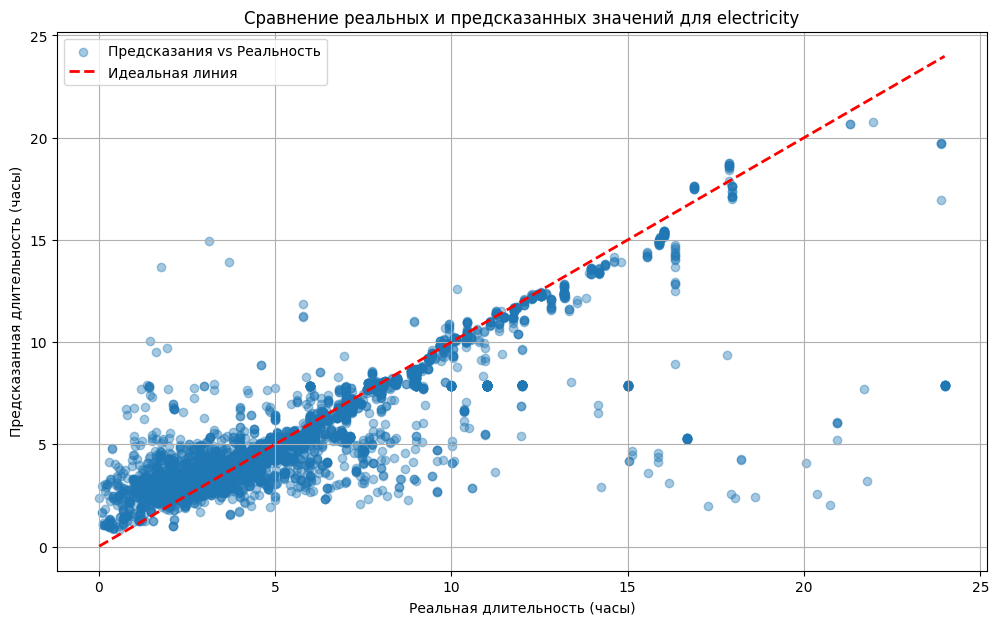


--- Оценка модели для типа cold_water ---
Размер выборок (train/val/test): 31399 / 5541 / 9236
RMSE (Root Mean Squared Error): 4.5904
R^2 Score: 0.6962
Файлы: модель -> improved_duration_predictor_cold_water.pth, scaler -> duration_scaler_cold_water.joblib
Размер выборок (train/val/test): 31399 / 5541 / 9236
RMSE (Root Mean Squared Error): 4.5904
R^2 Score: 0.6962
Файлы: модель -> improved_duration_predictor_cold_water.pth, scaler -> duration_scaler_cold_water.joblib


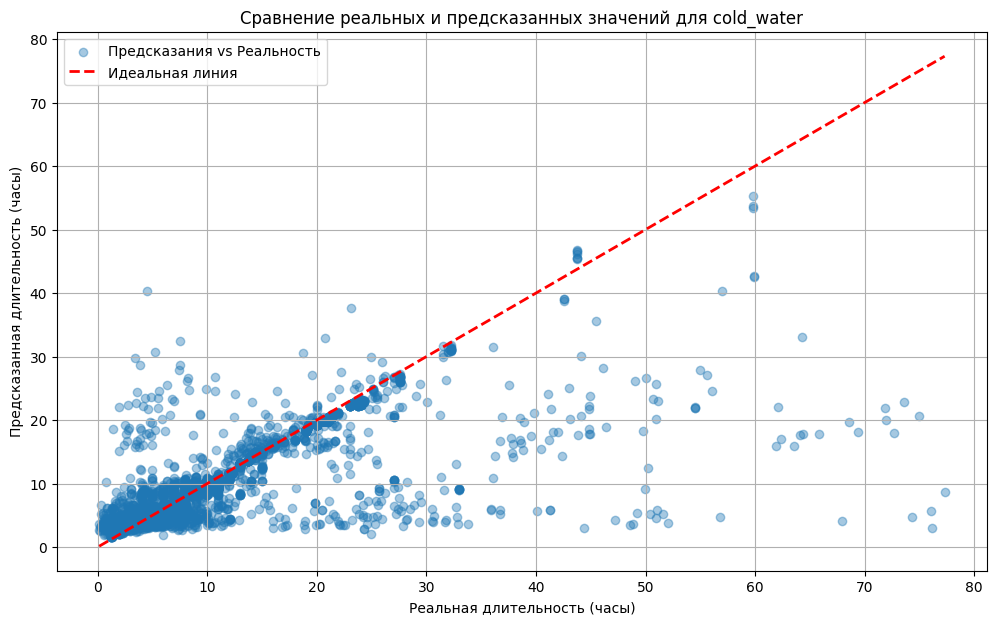


--- Оценка модели для типа heat ---
Размер выборок (train/val/test): 5995 / 1059 / 1764
RMSE (Root Mean Squared Error): 3.8992
R^2 Score: 0.8450
Файлы: модель -> improved_duration_predictor_heat.pth, scaler -> duration_scaler_heat.joblib


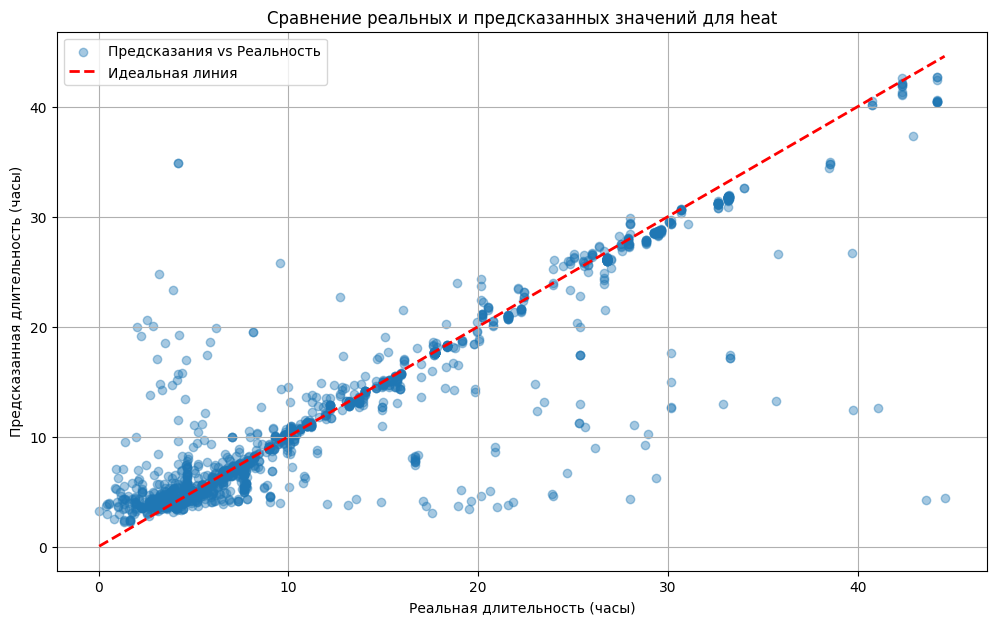

In [20]:
# --- 8. Оценка моделей на тестовых выборках ---


if not trained_models:
    print("Нет обученных моделей для оценки.")
else:
    for type_name, artifacts in trained_models.items():
        print(f"\n--- Оценка модели для типа {type_name} ---")
        model = artifacts["model"]
        test_loader = artifacts["test_loader"]


        model.eval()
        all_preds = []
        all_labels = []


        with torch.no_grad():
            for features, labels in test_loader:
                features = features.to(DEVICE)
                outputs = model(features)
                all_preds.extend(outputs.cpu().numpy().flatten())
                all_labels.extend(labels.numpy().flatten())


        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)


        if all_labels.size == 0:
            print("Нет данных в тестовой выборке для оценки.")
            continue


        rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
        r2 = r2_score(all_labels, all_preds)


        counts = artifacts["counts"]
        print(
            f"Размер выборок (train/val/test): {counts['train']} / "
            f"{counts['val']} / {counts['test']}"
        )
        print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
        print(f"R^2 Score: {r2:.4f}")
        print(
            f"Файлы: модель -> {artifacts['model_path']}, scaler -> {artifacts['scaler_path']}"
        )


        plt.figure(figsize=(12, 7))
        plt.scatter(all_labels, all_preds, alpha=0.4, label='Предсказания vs Реальность')
        min_val = min(all_labels.min(), all_preds.min())
        max_val = max(all_labels.max(), all_preds.max())
        plt.plot(
            [min_val, max_val],
            [min_val, max_val],
            'r--',


            lw=2,
            label='Идеальная линия',
        )
        plt.xlabel("Реальная длительность (часы)")
        plt.ylabel("Предсказанная длительность (часы)")
        plt.title(f"Сравнение реальных и предсказанных значений для {type_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

In [21]:
# --- 9. Краткое резюме по моделям ---


summary_rows = []


for type_name, config in TYPE_CONFIGS.items():
    trained = type_name in trained_models


    summary_rows.append(
        {
            "type_name": type_name,
            "type_id": config["type_id"],
            "duration_cap_hours": config["duration_limit"],
            "model_file": config["model_path"],
            "scaler_file": config["scaler_path"],
            "trained": "yes" if trained else "no",
            "train_samples": trained_models[type_name]["counts"]["train"] if trained else 0,
            "val_samples": trained_models[type_name]["counts"]["val"] if trained else 0,
            "test_samples": trained_models[type_name]["counts"]["test"] if trained else 0,
        }
    )


summary_df = pd.DataFrame(summary_rows)


print("Распределение типов и соответствующих моделей:")


if not summary_df.empty:
    display(summary_df)
else:
    print("Нет данных для отображения — проверьте процесс обучения.")

Распределение типов и соответствующих моделей:


,type_name,type_id,duration_cap_hours,model_file,scaler_file,trained,train_samples,val_samples,test_samples
0,electricity,1,24,improved_duration_predictor_electricity.pth,duration_scaler_electricity.joblib,yes,47514,8385,13975
1,cold_water,2,80,improved_duration_predictor_cold_water.pth,duration_scaler_cold_water.joblib,yes,31399,5541,9236
2,heat,4,45,improved_duration_predictor_heat.pth,duration_scaler_heat.joblib,yes,5995,1059,1764
